# Desafio #QuarentenaDados

Bem-vinda e bem-vindo ao desafio #QuarentenaDados valendo um **Nintendo Switch**!

Esse notebook traz informações dos dados e como você deve configurar seu arquivo final para submissão.

**Caso queira usar esse notebook como exemplo para desenvolver seu projeto, clique em file e escolha a opção Save a copy in Drive**


Vamos trabalhar com uma amostra aleatória da base de dados MICRODADOS ENEM 2018, essa amostra é **diferente da apresentada em aula**. Junto com a divulgação do resultado final estaremos disponibilizando o código que gerou os dados para que você possa analisar e reproduzir os datasets. 

Seu objetivo é prever da melhor forma possível a nota das provas de **linguagens e códigos** (NU_NOTA_LC), dado todas as outras notas. O modelo que tiver o menor **erro quadrático médio (MSE)** vence o desafio.

Para o desafio você tem três bases à disposição, duas para desenvolver seu modelo e uma para submissão da predição. As bases são as seguintes:

- **dados_treino**: São 1500000 linhas contendo a nota das 4 provas + nota de redação.

- **dados_teste**: São 20000 linhas contendo com notas das 4 provas + nota de redação.

- **dados_desafioqt**: São 10000 linhas com nota de 3 provas + nota de redação. A nota da prova de **Linguagem e Codigos** (NU_NOTA_LC) não está disponível nessa base.


As base **dados_treino e dados_teste**, contém as seguintes colunas; **NU_NOTA_CN, NU_NOTA_CH, NU_NOTA_MT, NU_NOTA_REDACAO, NU_NOTA_LC** (Você pode consultar a aula 5, onde o Guilherme explica o significado das siglas). A coluna que você deve realizar a **previsão** é **NU_NOTA_LC**. Você pode manipular os dados da forma que quiser, o importante é que no final submeta o arquivo com as informações corretas (detalhes da submissão serão discutidos no final deste notebook).

A base **dados_desafioqt**, contém as seguintes colunas; **ID, NU_NOTA_CN, NU_NOTA_CH, NU_NOTA_MT, NU_NOTA_REDACAO**. Repare que os dados **NU_NOTA_LC** não estão presentes, essa é justamente a informação que você precisa prever. Nós temos os valores reais das notas, no final do prazo de submissão um script irá avaliar sua previsão e dará uma nota para o seu modelo. Nessa base também temos o **ID**, essa informação é importante para o envio da sua previsão, garanta que a nota prevista corresponda ao respectivo **ID**.

Se você está habituado com o desenvolvimento de modelos de ML, repare que essa divisão de dados é exatamente a mesma que Treino, Teste e Validação. 

Abaixo preparamos um código exemplo para você seguir, sinta-se à vontade para experimentar diversos outros métodos, mas **GARANTA QUE O ARQUIVO DE SUBMISSÃO ESTEJA CONFIGURADO CORRETAMENTE**.

Na primeira parte, estamos lendo a base de dados direto de arquivos no github.






# Importando Dados & Bibliotecas
Rode essas células

In [0]:
import pandas as pd

# %precision %.2f
pd.options.display.float_format = '{:,.2f}'.format

URI_TREINO = "https://github.com/tgcsantos/quaretenadados/blob/master/DADOS_TREINO.csv?raw=true"
URI_TESTE = "https://github.com/tgcsantos/quaretenadados/raw/master/DADOS_TESTE.csv"
URI_DESAFIOQT = "https://github.com/tgcsantos/quaretenadados/raw/master/DESAFIOQT.csv"

dados_treino = pd.read_csv(URI_TREINO)
dados_teste = pd.read_csv(URI_TESTE)
dados_desafioqt = pd.read_csv(URI_DESAFIOQT)

erro_treino = "Erro ao carregar dados de treino"
erro_teste = "Erro ao carregar dados de teste"
erro_desafioqt = "Erro ao carregar dados de submissão"

assert dados_treino.shape == (150000, 5), erro_treino
assert dados_teste.shape == (20000, 5), erro_teste
assert dados_desafioqt.shape == (10000, 5), erro_desafioqt

In [0]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

from sklearn.metrics import mean_squared_error # Metrica de qualidade

# Explorando os Dados

In [3]:
dados_treino.head(3)

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
0,530.70,586.50,575.90,539.00,520.00
1,439.40,577.90,440.90,488.70,380.00
2,414.10,548.80,417.20,382.60,600.00


Achando valores '0' e 'NaN'

In [4]:
print(f"Quantidade de linhas com 0 nos dados de treino: {dados_treino.query('NU_NOTA_CN == 0 | NU_NOTA_CH == 0 | NU_NOTA_LC == 0 | NU_NOTA_MT == 0').shape}")
print(f"Quantidade de linhas com 0 nos dados de teste: {dados_teste.query('NU_NOTA_CN == 0 | NU_NOTA_CH == 0 | NU_NOTA_LC == 0 | NU_NOTA_MT == 0').shape}")
print(f'As notas "0" equivalem a: {(180 * 100)/150000}%')
print(f"Quantidade de linhas com 0 nos dados de teste: {dados_treino.query('NU_NOTA_REDACAO == 0').shape}")

Quantidade de linhas com 0 nos dados de treino: (180, 5)
Quantidade de linhas com 0 nos dados de teste: (23, 5)
As notas "0" equivalem a: 0.12%
Quantidade de linhas com 0 nos dados de teste: (3067, 5)


In [5]:
dados_treino.dropna().shape # Não há valores 'NaN'

(150000, 5)

- **nota**: As provas do enem tem um sistema de nota 'adaptativo', onde se torna 'imposível' tirar nota 0 ou 1000. Entretanto, a redação não segue essa regra, sendo possível tirar 1000 e 0 se tiver condições que anulem a nota.

In [0]:
dados_treino_s0 = dados_treino.query('NU_NOTA_CN > 0 & NU_NOTA_CH > 0 & NU_NOTA_LC > 0 & NU_NOTA_MT > 0')

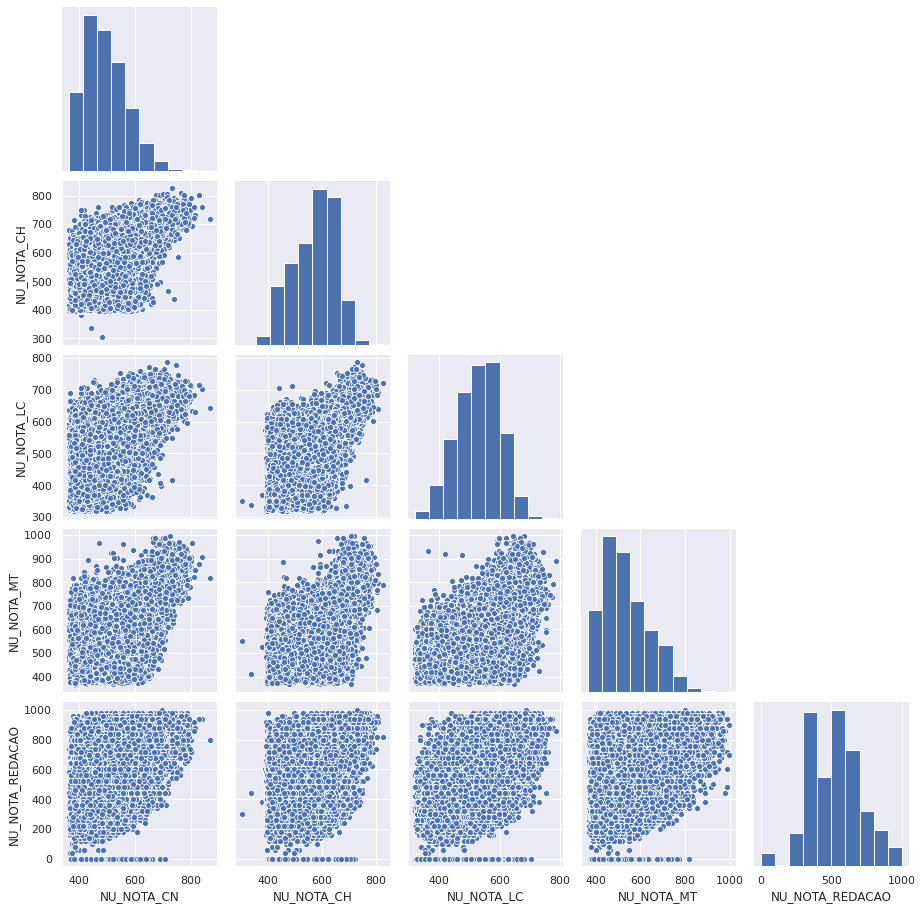

In [27]:
sns.pairplot(dados_treino_s0, corner=True)

In [8]:
dados_treino_s0.describe()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
count,"149,820.00","149,820.00","149,820.00","149,820.00","149,820.00"
mean,493.98,571.35,528.80,535.74,516.46
std,73.98,77.26,71.58,102.87,184.21
min,362.50,304.20,318.80,364.40,0.00
25%,435.80,513.50,478.10,455.60,360.00
50%,483.70,585.00,533.50,516.80,520.00
75%,542.50,629.70,581.40,601.00,640.00
max,869.60,825.80,787.40,996.10,"1,000.00"


# Testando a BaseLine

Agora com as bases de dados lidas, vamos separar as informações de cada dataset. X_treino e Y_treino são as **features**, X_teste e Y_teste são as **labels** a serem previstas.

Duas observações nesta parte:

- 1° Como já disponibilizamos os dados de treino e teste separados, você não precisa fazer *train_test_split* feito em aula (porém fique à vontade para trabalhar da forma que achar melhor).

- 2° Transformamos X_treino, Y_treino, X_teste, Y_teste em arrays numpy. Se você quiser usar uma biblioteca que não aceite dataframe como entrada de dados, já deixamos pronto para você.

In [64]:
# from sklearn.model_selection import train_test_split                          Dados já divididos...

coluna_label = 'NU_NOTA_LC'
coluna_features = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']

X_treino = dados_treino[coluna_features].to_numpy()
Y_treino = dados_treino[coluna_label].to_numpy()
X_teste = dados_teste[coluna_features].to_numpy()
Y_teste = dados_teste[coluna_label].to_numpy()

X_treino.shape, Y_treino.shape, X_teste.shape, Y_teste.shape

((150000, 4), (150000,), (20000, 4), (20000,))

## Feature Engineering

In [0]:
dados_treino_s0 = dados_treino.query('NU_NOTA_CN > 0 & NU_NOTA_CH > 0 & NU_NOTA_LC > 0 & NU_NOTA_MT > 0')
X_treino_s0 = dados_treino_s0[coluna_features].to_numpy()
Y_treino_s0 = dados_treino_s0[coluna_label].to_numpy()

X_treino_CH = dados_treino['NU_NOTA_CH'].to_numpy().reshape(-1,1)
X_teste_CH = dados_teste[['NU_NOTA_CH']].to_numpy().reshape(-1,1)

- **nota**: Retirar os valores zeros dos dados de treino teve uma mizera ''piora'' no MSE.<br>
- **nota**: Retirar algumas features e combina-las teve uma piora no modelo.

## Verificando a Baseline com dummy

A seguir criamos um modelo **Dummy** como exemplo e realizamos a avaliação do modelo com o **mean_squared_error**. 

Você pode usar qualquer algoritmo ou biblioteca para criar seus modelos, mas garanta que fará a avaliação com o mean_squared_error, pois usaremos essa métrica para avaliar sua predição final.

In [0]:
from sklearn.dummy import DummyRegressor

In [0]:
modelo_dummy = DummyRegressor() #Exemplo de classificação com Dummy
modelo_dummy.fit(X_treino, Y_treino)
dummy_predicoes = modelo_dummy.predict(X_teste)

avaliacao_dummy = mean_squared_error(Y_teste, dummy_predicoes)

print(f"Minha avaliação nos dados de teste foi de {avaliacao_dummy}")

Minha avaliação nos dados de teste foi de 5219.286870186777


In [0]:
modelo_dummy = DummyRegressor()
modelo_dummy.fit(X_treino_s0, Y_treino_s0)
dummy_predicoes = modelo_dummy.predict(X_teste)

avaliacao_dummy = mean_squared_error(Y_teste, dummy_predicoes)

print(f"Minha avaliação Dummy nos dados de teste foi de {avaliacao_dummy}")

Minha avaliação Dummy nos dados de teste foi de 5219.655641602282


- **nota**: Houve uma piora pequena no modelo dummy ao tirar os zeros do dataset de treino

## Pré processando os dados

Definitivamente, não...

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
sc_X = StandardScaler()
X_treino_sc = sc_X.fit_transform(X_treino)
X_teste_sc = sc_X.transform(X_teste)
sc_Y = StandardScaler()
Y_treino_sc = sc_Y.fit_transform((Y_treino).reshape(-1,1))

In [0]:
print(X_treino_sc,'\n','-'*50)
print(Y_treino_sc)

[[ 0.49639048  0.19833571  0.03285354  0.02023347]
 [-0.7348236   0.09002261 -0.45533938 -0.73917252]
 [-1.0760034  -0.27647871 -1.48510615  0.45417975]
 ...
 [-0.30868598 -0.1517927   0.07070548 -0.30522624]
 [-0.23181938 -1.35079357 -0.98623705 -2.80041734]
 [ 1.94067337  0.51319938  1.9031274   0.45417975]] 
 --------------------------------------------------
[[ 0.65445898]
 [-1.21056503]
 [-1.53798035]
 ...
 [ 0.74425643]
 [ 0.34224015]
 [ 0.07422929]]


 # Testando os Modelos

In [0]:
from sklearn.linear_model import LinearRegression # Mais simples é melhor \o/
from sklearn.svm import LinearSVR # Nhã...
from sklearn.tree import DecisionTreeRegressor # tão dummy quanto?!
from sklearn.ensemble import RandomForestRegressor # Opa, melhorou
from sklearn.linear_model import SGDRegressor # Uma S#1t! Ops, c/loss=squared
from sklearn.ensemble import GradientBoostingRegressor # Muito bom!
from sklearn.ensemble import ExtraTreesRegressor  # Extra oq?!
from sklearn.neural_network import MLPRegressor # Primeira RN...
from sklearn.ensemble import VotingRegressor # Ideia Interessante...
from xgboost import XGBRegressor # Copia do GBR? 2046 Gezz...

from math import sqrt # Pra calcular RMSE de MSE.

In [0]:
# Testando todos de uma vez
np.random.seed(0)
nomes = ['LNR', 'SVR', 'DTR', 'RFR', 'SGD', 'GBR', 'ETR', 'MLP']
lista_modelos = [LinearRegression(), LinearSVR(max_iter=100000, C = 0.01),
                 DecisionTreeRegressor(), RandomForestRegressor(), 
                 SGDRegressor(loss='huber'), GradientBoostingRegressor(),
                 ExtraTreesRegressor(), MLPRegressor()]
for n in range(0, len(lista_modelos)):
  print(f'{nomes[n]} - MSE: {mean_squared_error(Y_teste,(lista_modelos[n].fit(X_treino, Y_treino).predict(X_teste))):,.2f}')

LNR - MSE: 2,177.38
SVR - MSE: 2,314.67
DTR - MSE: 4,193.52
RFR - MSE: 2,208.13
SGD - MSE: 2,493.92
GBR - MSE: 2,046.39
ETR - MSE: 2,292.96
MLP - MSE: 2,113.27


Text(0, 0.5, 'Erro da predição')

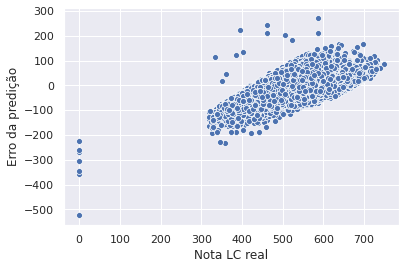

In [0]:
sns.scatterplot(x = Y_teste, y = Y_teste - GBR_predicao) # Melhor modelo
plt.xlabel('Nota LC real')
plt.ylabel('Erro da predição')

## Testando na mão


### - *LinearRegression* - MSE: 2,177.38 / RMSE: 46.66

LinearRegression - MSE: 2,177.38 / RMSE: 46.66


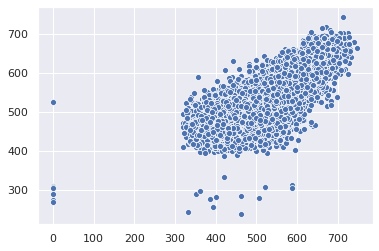

In [63]:
modelo_LR = LinearRegression()
modelo_LR.fit(X_treino, Y_treino)
LR_predicao = modelo_LR.predict(X_teste)
avaliacao_LR = mean_squared_error(Y_teste, LR_predicao)
print(f"LinearRegression - MSE: {avaliacao_LR:,.2F} / RMSE: {sqrt(avaliacao_LR):,.2F}")

sns.scatterplot(x=Y_teste, y= LR_predicao)

### -  GradientBoostingRegressor: 2046.3830809834324

In [0]:
modelo_GBR = GradientBoostingRegressor(random_state=0)
modelo_GBR.fit(X_treino, Y_treino)
print(modelo_GBR.feature_importances_)
GBR_predicao = modelo_GBR.predict(X_teste)
avaliacao_GBR = mean_squared_error(Y_teste, GBR_predicao)
print(f"GradientBoostingRegressor: {avaliacao_GBR}")

[0.05858767 0.81955739 0.04854068 0.07331426]
GradientBoostingRegressor: 2046.3830809834324


In [115]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_treino, Y_treino)
errors = [mean_squared_error(Y_teste, y_pred) for y_pred in gbrt.staged_predict(X_teste)]
best_number_of_estimators = np.argmin(errors)
gbrt_best = GradientBoostingRegressor(max_depth=2, random_state=0,
                                      n_estimators=best_number_of_estimators)
gbrt_best.fit(X_treino, Y_treino)
print(gbrt_best.feature_importances_)
GBR_p = gbrt_best.predict(X_teste)
a_GBR = mean_squared_error(Y_teste, GBR_p)
print(f"GradientBoostingRegressor: {a_GBR}")

[0.07731801 0.77086359 0.06084307 0.09097532]
GradientBoostingRegressor: 2057.7933992046005


### - LinearSVR: 2314.6742381259555

In [0]:
modelo_SVR = LinearSVR(max_iter=100000, C = 0.01, random_state=0)
modelo_SVR.fit(X_treino, Y_treino)
SVR_predicao = modelo_SVR.predict(X_teste)
avaliacao_SVR = mean_squared_error(Y_teste, SVR_predicao)
print(f"LinearSVR: {avaliacao_SVR}")

LinearSVR: 2314.6742381259555


### - DecisionTreeRegressor: 4219.727957499999

In [0]:
modelo_DTR = DecisionTreeRegressor(random_state=0)
modelo_DTR.fit(X_treino, Y_treino)
DTR_predicao = modelo_DTR.predict(X_teste)
avaliacao_DTR = mean_squared_error(Y_teste, DTR_predicao)
print(f"DecisionTreeRegressor: {avaliacao_DTR}")

DecisionTreeRegressor: 4219.727957499999


### - RandomForestRegressor: 2208.10869803665

In [0]:
modelo_RFR = RandomForestRegressor(random_state=0)
modelo_RFR.fit(X_treino, Y_treino)
RFR_predicao = modelo_RFR.predict(X_teste)
avaliacao_RFR = mean_squared_error(Y_teste, RFR_predicao)
print(f"RandomForestRegressor: {avaliacao_RFR}")

RandomForestRegressor: 2208.10869803665


### - SGDRegressor: 2448.948550101472

In [0]:
modelo_SGD = SGDRegressor(loss="huber", random_state=0)
modelo_SGD.fit(X_treino, Y_treino)
SGD_predicao = modelo_SGD.predict(X_teste)
avaliacao_SGD = mean_squared_error(Y_teste, SGD_predicao)
print(f"SGDRegressor: {avaliacao_SGD}")

SGDRegressor: 2448.948550101472


### - ExtraTreesRegressor: 2302.69382858175

In [0]:
modelo_ETR = ExtraTreesRegressor(random_state=0)
modelo_ETR.fit(X_treino, Y_treino)
print(modelo_ETR.feature_importances_)
ETR_predicao = modelo_ETR.predict(X_teste)
avaliacao_ETR = mean_squared_error(Y_teste, ETR_predicao)
print(f"ExtraTreesRegressor: {avaliacao_ETR}")

[0.19730178 0.40501857 0.20319884 0.19448082]
ExtraTreesRegressor: 2302.69382858175


### - VotingRegressor 2164.7708657068647

In [0]:
reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
reg3 = LinearRegression()
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg = ereg.fit(X_treino, Y_treino)

VTR_predicao = ereg.predict(X_teste)
avaliacao_VTR = mean_squared_error(Y_teste, VTR_predicao)
print(f"VotingRegressor: {avaliacao_VTR}")

MLPRegressor: 2164.7708657068647


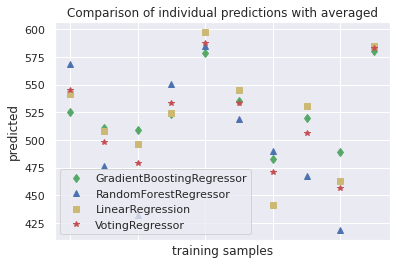

In [0]:
reg1.fit(X_treino, Y_treino)
reg2.fit(X_treino, Y_treino)
reg3.fit(X_treino, Y_treino)
ereg.fit(X_treino, Y_treino)

xt = X_treino[:10]

plt.figure()
plt.plot(reg1.predict(xt), 'gd', label='GradientBoostingRegressor')
plt.plot(reg2.predict(xt), 'b^', label='RandomForestRegressor')
plt.plot(reg3.predict(xt), 'ys', label='LinearRegression')
plt.plot(ereg.predict(xt), 'r*', label='VotingRegressor')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Comparison of individual predictions with averaged')
plt.show()

### - StackingRegressor: Não rodou...

In [0]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.svm import SVR
estimators = [('ridge', RidgeCV()),
              ('lasso', LassoCV(random_state=42)),
              ('svr', SVR(C=1, gamma=1e-6))]
modelo_STR = StackingRegressor(estimators=estimators,
                               final_estimator=
                               GradientBoostingRegressor(random_state=1))
modelo_STR.fit(X_treino, Y_treino)
STR_predicao = modelo_STR.predict(X_teste)
avaliacao_STR = mean_squared_error(Y_teste, STR_predicao) 
print(f"StackingRegressor: {avaliacao_STR}")

### - XGBRegressor: 2046.9509425824888

In [127]:
modelo_XGR = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                          objective='reg:squarederror')
modelo_XGR.fit(X_treino, Y_treino, verbose=False,
               early_stopping_rounds=4,
               eval_set=[(X_teste, Y_teste)])
EXR_predicao = modelo_XGR.predict(X_teste)
avaliacao_XGR = mean_squared_error(Y_teste, EXR_predicao)
print(f'XGBRegressor: {avaliacao_XGR}')

XGBRegressor: 2049.1839698764666


# Tunando o Modelo

## - Na mão...

In [0]:
modelo_GBR = GradientBoostingRegressor(random_state=0, n_estimators=140) #de 2046 pra 2045, really?! Nem pra ser 2048...
modelo_GBR.fit(X_treino, Y_treino)
GBR_predicao = modelo_GBR.predict(X_teste)
avaliacao_GBR = mean_squared_error(Y_teste, GBR_predicao)
print(f"GradientBoostingRegressor: {avaliacao_GBR}")

GradientBoostingRegressor: 2045.4586083966333


In [0]:
lista = [(100,),(200,),(350,),(500,)]
for n in lista:  
  modelo_MPL = MLPRegressor(random_state=0, hidden_layer_sizes=n,
                            learning_rate_init = 0.0027013043185379216, 
                            max_iter = 212)
  modelo_MPL.fit(X_treino, Y_treino)
  MPL_predicao = modelo_MPL.predict(X_teste)
  avaliacao_MPL = mean_squared_error(Y_teste, MPL_predicao)
  print(f"MLPRegressor: {n} - {avaliacao_MPL}")

MLPRegressor: (100,) - 2081.5962736073407
MLPRegressor: (200,) - 2080.6262723618743
MLPRegressor: (350,) - 2161.154394411728
MLPRegressor: (500,) - 2076.48413620247


In [0]:
lista=[1]
for n in lista:
  modelo_RFR = RandomForestRegressor(random_state=0, min_samples_leaf=9, n_estimators=500, min_samples_split=9)
  modelo_RFR.fit(X_treino, Y_treino)
  RFR_predicao = modelo_RFR.predict(X_teste)
  avaliacao_RFR = mean_squared_error(Y_teste, RFR_predicao)
  print(f"RandomForestRegressor: {avaliacao_RFR}\n{n}")

RandomForestRegressor: 2107.3323357081345
1


## - Otimizando. Agora vai...

In [6]:
!pip install scikit-optimize

In [0]:
from skopt import gp_minimize

In [8]:
def tunar_modelo(params):
  learning_rate = params[0]
  n_estimators = params[1]
  min_samples_split = params[2]
  min_samples_leaf = params[3]

  print(params,'\n')
  modelo_GBR = GradientBoostingRegressor(learning_rate = learning_rate, n_estimators = n_estimators,
                                         min_samples_split = min_samples_split.astype(int), 
                                         min_samples_leaf = min_samples_leaf.astype(int), 
                                         random_state = 0) # [0.06, 422, 43, 43] 2045.2713
  modelo_GBR.fit(X_treino, Y_treino)
  GBR_predicao = modelo_GBR.predict(X_teste)
  return mean_squared_error(Y_teste, GBR_predicao)

space = [(1e-2, 1e-1), # learning_rate
         (1, 1000), # n_estimators
         (2, 100), # min_samples_split
         (1, 100)] # min_samples_leaf, # subsample, # max_features

resultado_gp = gp_minimize(tunar_modelo, space, random_state=0, n_calls=20, n_random_starts=10, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[0.06335601564025166, 844, 86, 85] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 136.0587
Function value obtained: 2045.8466
Current minimum: 2045.8466
Iteration No: 2 started. Evaluating function at random point.
[0.06612073271073753, 385, 31, 7] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 61.8386
Function value obtained: 2047.1205
Current minimum: 2045.8466
Iteration No: 3 started. Evaluating function at random point.
[0.0345390665122102, 478, 82, 49] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 77.2787
Function value obtained: 2045.2029
Current minimum: 2045.2029
Iteration No: 4 started. Evaluating function at random point.
[0.04535063164907469, 836, 35, 65] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 134.8367
Function value obtained: 2046.8602
Current minimum: 2045.2029
Iteration No: 5 started. Evaluating function at rand

In [9]:
resultado_gp.x

[0.07533962022628246, 578, 45, 84]

In [132]:
modelo_GBR_final = GradientBoostingRegressor(learning_rate = 0.03, n_estimators = 675, 
                                       min_samples_split = 33, min_samples_leaf = 70,
                                       random_state = 0)
modelo_GBR_final.fit(X_treino, Y_treino)
GBR_predicao_final = modelo_GBR_final.predict(X_teste)
avaliacao_GBR_final = mean_squared_error(Y_teste, GBR_predicao_final)
print(f"GradientBoostingRegressor - MSE: {avaliacao_GBR_final}")

GradientBoostingRegressor - MSE: 2042.856294882789


In [0]:
from skopt.plots import plot_convergence

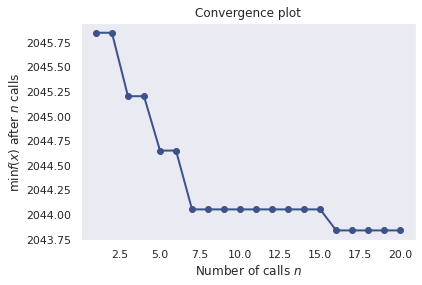

In [12]:
plot_convergence(resultado_gp)

### Mais Alguns...

In [0]:
# ?DecisionTreeRegressor

In [0]:
def tunar_modeloDTR(paramsDTR):
  criterion = paramsDTR[0]
  min_samples_split = paramsDTR[1]
  min_samples_leaf = paramsDTR[2]

  print(paramsDTR,'\n')
  modelo_DTR = DecisionTreeRegressor(criterion = criterion,
                                     min_samples_split = min_samples_split,
                                     min_samples_leaf = min_samples_leaf,
                                     random_state = 0)
  modelo_DTR.fit(X_treino, Y_treino)
  DTR_predicao = modelo_DTR.predict(X_teste)
  return mean_squared_error(Y_teste, DTR_predicao)

spaceDTR = [('mse', 'friedman_mse'), # criterion
         (2, 200), # min_samples_split
         (1, 200)] # min_samples_leaf

resultado_gpDTR = gp_minimize(tunar_modeloDTR, spaceDTR, random_state=0,
                              n_calls=30, n_random_starts=10, verbose=1)

In [0]:
resultado_gpDTR.x # melhor q isso impossivel... de 4,2k para 2,1k, kk
                  # esse x ['mse', 194, 164] ou este:['mse', 2, 131] nº17

In [0]:
def tunar_modeloSVR(paramsSVR):
  C = paramsSVR[0]
  max_iter = paramsSVR[1]

  print(paramsSVR,'\n')
  modelo_SVR = LinearSVR(C = C, max_iter = max_iter, 
                        random_state=0) #[0.09736099089921017, 100000] 2196.3993
  modelo_SVR.fit(X_treino, Y_treino)
  SVR_predicao = modelo_SVR.predict(X_teste)
  return mean_squared_error(Y_teste, SVR_predicao)

spaceSVR = [(1e-4, 0.1), # C
            (1, 100000)] # max_iter

resultado_gpSVR = gp_minimize(tunar_modeloSVR, spaceSVR, random_state=0,
                              n_calls=100, n_random_starts=20, verbose=1)

In [0]:
def tunar_modeloMLP(paramsMLP):
  learning_rate_init = paramsMLP[0]
  max_iter = paramsMLP[1]


  print(paramsMLP,'\n')
  modelo_MLP = MLPRegressor(learning_rate_init=learning_rate_init, max_iter=max_iter,
                            random_state=0) #[0.0027013043185379216, 212] 2081.4377
  modelo_MLP.fit(X_treino, Y_treino)
  MLP_predicao = modelo_MLP.predict(X_teste)
  return mean_squared_error(Y_teste, MLP_predicao)

spaceMLP = [(1e-3, 9e-3),
            (100, 1000)]

resultado_gpMLP = gp_minimize(tunar_modeloMLP, spaceMLP, random_state=0,
                              n_calls=100, n_random_starts=20, verbose=1)

In [29]:
def tunar_modeloXGR(paramsXGR):
  n_estimators = paramsXGR[0]
  learning_rate = paramsXGR[1]

  print(paramsXGR,'\n')
  modelo_XGR = XGBRegressor(n_estimators=n_estimators, 
                            learning_rate=learning_rate, 
                            objective='reg:squarederror')

  modelo_XGR.fit(X_treino, Y_treino)
  XGR_predicao = modelo_XGR.predict(X_teste)
  return mean_squared_error(Y_teste, XGR_predicao) #[1051, 0.04738992884254414] 2056.3730

spaceXGR = [(100, 5000),
            (1e-3, 1)]

resultado_gpXGR = gp_minimize(tunar_modeloXGR, spaceXGR, random_state=0,
                              n_calls=100, n_random_starts=20, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[5969, 0.8444214828324366] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 299.6184
Function value obtained: 2522.4354
Current minimum: 2522.4354
Iteration No: 2 started. Evaluating function at random point.
[8594, 0.8474044870453415] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 416.4442
Function value obtained: 2619.6968
Current minimum: 2522.4354
Iteration No: 3 started. Evaluating function at random point.
[6273, 0.3849973255854072] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 307.8429
Function value obtained: 2264.8318
Current minimum: 2264.8318
Iteration No: 4 started. Evaluating function at random point.
[3046, 0.05765626434012575] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 147.8545
Function value obtained: 2063.0190
Current minimum: 2063.0190
Iteration No: 5 started. Evaluating function at random point.
[2799, 0.47818745

# Salvando e Baixando to_csv

Depois que você criou testou e validou seu modelo, chegou a hora de preparar seu arquivo para a submissão do resultado.

No código abaixo, estamos realizando a predição das notas de **linguagem e códigos** do dataset **dados_desafioqt**. Feita a previsão, criamos um dataframe novo para a submissão, primeiro crimos a coluna **ID** e adicionamos a coluna **NU_NOTA_LC** com suas respectivas previsões (repare que nosso modelo não alterou as ordens dos ID's, mas se você utilizar algum modelo que embaralhe essa ordem certifique de colocar a previsão correta para o ID correto).

Após isso, salvamos o dataframe com ´.to_csv()´ (**importante, passe o parâmetro index=False para `.to_csv()`, caso contrário nosso script não computará sua nota**) no arquivo **PREDICAO_DESAFIOQT.csv (você precisa submeter o arquivo com esse nome, caso contrário nosso script de avaliação não computará sua nota**)  e utilizamos o `files.download` para baixar o arquivo em sua máquina local.

Feito tudo isso você está quase pronto para finalizar e submeter seu resultado. Você já baixou os dados, treinou e validou seu modelo, salvou sua previsão **no padrão ideal para submissão** e já está com o modelo baixado em sua máquina. Entretanto, ainda falta um detalhe: no momento de preencher o **forms** você precisa enviar seu código. Caso esteja usando os notebooks do colab siga as seguintes instruções para o download:

- Clique em **File** na parte superior esquerda.
- Depois selecione a opção **Download .ipynb** (também aceitaremos o .py caso você prefira desenvolver seu projeto em um arquivo python).


Pronto agora é só submeter seu resultado e torcer para levar um **Nintendo Switch** para casa.

Boa sorte!

In [0]:
#atribuir ao MODELO o nome do seu melhor modelo
from google.colab import files

MODELO = modelo_GBR_final
X_desafioqt = dados_desafioqt[coluna_features].to_numpy()
predicao_desafioqt = MODELO.predict(X_desafioqt)


desafio_df = pd.DataFrame(dados_desafioqt.ID)
desafio_df[coluna_label] = predicao_desafioqt

#NÃO TROCAR O NOME DO ARQUIVO DE SAÍDA (PREDICAO_DESAFIO)
desafio_df.to_csv('PREDICAO_DESAFIOQT.csv', index=False) 
files.download('PREDICAO_DESAFIOQT.csv')

